let's load the dependencies

In [1]:
import pandas as pd
import os
from tqdm import tqdm
import seaborn as sns
import mne
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.stats import pearsonr

In [2]:
def filter(data): # Pass sampling rate as an argument
    # median filter to remove artifacts
    # data = signal.medfilt(data, kernel_size=3) # Uncomment if needed

    # --- High-Pass Filter ---
    hpf_cutoff = 1  # Hz - Recommended for ERPs to remove slow drift
    hpf_order = 4     # Filter order (can be same or different from LPF)

    # Design Butterworth HPF
    # Note: fs/2 is the Nyquist frequency
    b_high, a_high = signal.butter(hpf_order, hpf_cutoff / 100, btype='high')

    # Apply HPF using zero-phase filtering
    # Apply along the time axis (assuming channels x time or trials x channels x time)
    data_hpf = signal.filtfilt(b_high, a_high, data, axis=-1)

    # --- Low-Pass Filter ---
    lpf_cutoff = 40.0  # Hz - Typical for ERPs
    lpf_order = 4      # Filter order

    # Design Butterworth LPF
    b_low, a_low = signal.butter(lpf_order, lpf_cutoff / 100, btype='low')

    # Apply LPF using zero-phase filtering to the high-passed data
    filtered_data = signal.filtfilt(b_low, a_low, data_hpf, axis=-1)

    return filtered_data

let's read the csv files, filter the time series and epoch them

In [ ]:
all_epochs = []
all_labels = pd.read_csv('TrainLabels.csv').Prediction.values

for filename in tqdm(os.listdir('train')): # Loop through all sessions
    session_data = pd.read_csv('train/' + filename) # Load one session
    for channel in channels:
        session_data[channel] = filter(session_data[channel].values) # filter each EEG channel
    
    # session_data['EOG'] = preprocess(session_data['EOG'].values) # filter the EOG time series

    session_feedback_ids = session_data[session_data['FeedBackEvent'] == 1].index # identify the event markers
    session_epochs = [] # list to store all epochs in the session
    for idx in session_feedback_ids:
        epoch = session_data.loc[idx-40:idx + 199] # 200ms before and 1000ms after the event
        baseline = session_data.loc[idx-40:idx, channels].values.mean(axis=0) # calculate the baseline
        epoch.loc[:, channels] -= baseline # baseline correction
        session_epochs.append(epoch) # append the epoch to the list of all epochs in the session
    
    all_epochs.extend(session_epochs) # add the epochs to the list of all epochs

100%|██████████| 80/80 [07:23<00:00,  5.54s/it]


let us filter our time series, filter them, run ICA to get rid of the EOG components, and epoch them

In [ ]:
eeg_channels = ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3',
    'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz',
    'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4',
    'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6',
    'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7',
    'POz', 'P08', 'O1', 'O2']

eog_channel = 'EOG' 

all_channels = eeg_channels + [eog_channel]

all_epochs = [] # Store cleaned EEG epochs
all_labels = pd.read_csv('TrainLabels.csv').Prediction.values

# --- Loop through sessions ---
for filename in tqdm(os.listdir('train')):
    session_data = pd.read_csv(os.path.join('train', filename))

    # --- 1. Filter EEG and EOG Channels ---
    print(f"\nProcessing {filename}...")
    for channel in all_channels:
        session_data[channel] = filter(session_data[channel].values)

    # --- 2. Prepare Continuous Data for ICA ---
    # Shape: (n_channels, n_timepoints)
    eeg_data = session_data[eeg_channels].values.T
    eog_data = session_data[eog_channel].values.reshape(1, -1) # Keep as 2D array

    # Transpose for sklearn: (n_timepoints, n_features)
    eeg_data_skl = eeg_data.T
    eog_data_skl = eog_data.T

    # --- 3. Standardize Data ---
    scaler_eeg = StandardScaler()
    eeg_data_scaled = scaler_eeg.fit_transform(eeg_data_skl)

    scaler_eog = StandardScaler()
    eog_data_scaled = scaler_eog.fit_transform(eog_data_skl) # Scale EOG separately

    # --- 4. Fit ICA on EEG Data ---
    n_components_ica = len(eeg_channels) # Use number of EEG channels as components
    ica = FastICA(n_components=n_components_ica,
                    random_state=42,
                    whiten='unit-variance', # Recommended for FastICA
                    max_iter=1000, # Increase iterations if convergence is an issue
                    tol=0.001)     # Convergence tolerance

    print("Fitting ICA...")
    sources_eeg = ica.fit_transform(eeg_data_scaled) # Shape: (n_timepoints, n_components_ica)
    print("ICA fitting complete.")

    # --- 5. Identify EOG Component(s) via Correlation ---
    print("Identifying EOG components...")
    correlations = []
    eog_signal_flat = eog_data_scaled.flatten() # Ensure EOG is 1D for correlation

    for i in range(sources_eeg.shape[1]):
        component_signal = sources_eeg[:, i]
        # Calculate Pearson correlation coefficient and p-value
        corr, p_value = pearsonr(eog_signal_flat, component_signal)
        correlations.append(abs(corr)) # Use absolute correlation

        eog_component_index = np.argmax(correlations)
        max_corr = correlations[eog_component_index]
        print(f"Removing component {eog_component_index} with correlation: {max_corr:.4f}")
        eog_components = [eog_component_index]

        # --- 6. Remove EOG Component(s) ---
        sources_cleaned = sources_eeg.copy()
        # Zero out all identified EOG components
        sources_cleaned[:, eog_component_index] = 0
        print(f"Zeroed out component {eog_component_index}.")

    # --- 7. Reconstruct Cleaned EEG Data ---
    print("Reconstructing cleaned EEG data...")
    # Use inverse_transform to go from sources back to sensor space
    eeg_data_cleaned_scaled = ica.inverse_transform(sources_cleaned)

    # --- 8. Un-standardize Cleaned EEG Data ---
    eeg_data_cleaned_unscaled = scaler_eeg.inverse_transform(eeg_data_cleaned_scaled)

    # Prepare cleaned data for epoching (back to DataFrame structure)
    eeg_data_to_epoch = pd.DataFrame(eeg_data_cleaned_unscaled, columns=eeg_channels, index=session_data.index)
    print("EEG data cleaned.")


    # --- 9. Epoching
    session_feedback_ids = session_data[session_data['FeedBackEvent'] == 1].index
    session_epochs = []
    print(f"Epoching {len(session_feedback_ids)} events...")
    for idx in session_feedback_ids:
        # Define epoch window relative to event index
        start_idx = idx - 40  # 200ms before (40 samples at 200Hz)
        end_idx = idx + 199 # 1000ms after (200 samples at 200Hz) -> inclusive index for .loc

        # Define baseline window relative to event index
        baseline_start_idx = idx - 40 # 200ms before
        baseline_end_idx = idx      # Up to (but not including) the event

        # Extract epoch data for EEG channels
        epoch_data = eeg_data_to_epoch.loc[start_idx:end_idx].copy()

        # Calculate baseline using the correct window from the *epoched* data
        baseline_data = epoch_data.loc[baseline_start_idx:baseline_end_idx]
        baseline_mean = baseline_data.mean(axis=0)

        # Apply baseline correction
        epoch_data -= baseline_mean

        # Append the baseline-corrected epoch (EEG channels only)
        session_epochs.append(epoch_data.values) # Append numpy array

    all_epochs.extend(session_epochs) # Add the cleaned epochs to the list
    print(f"Finished {filename}. Total epochs collected: {len(all_epochs)}")


# --- Convert cleaned epochs to NumPy array ---
# Shape: (n_epochs, n_timepoints_in_epoch, n_eeg_channels)
# all_epochs_clean_np = np.array(all_epochs)
# print(f"Final shape of cleaned epochs array: {all_epochs_clean_np.shape}")

  0%|          | 0/80 [00:00<?, ?it/s]


Processing Data_S02_Sess01.csv...
Fitting ICA...
ICA fitting complete.
Identifying EOG components...
Removing component 0 with correlation: 0.0298
Zeroed out component 0.
Removing component 0 with correlation: 0.0298
Zeroed out component 0.
Removing component 2 with correlation: 0.0400
Zeroed out component 2.
Removing component 2 with correlation: 0.0400
Zeroed out component 2.
Removing component 2 with correlation: 0.0400
Zeroed out component 2.
Removing component 2 with correlation: 0.0400
Zeroed out component 2.
Removing component 2 with correlation: 0.0400
Zeroed out component 2.
Removing component 2 with correlation: 0.0400
Zeroed out component 2.
Removing component 2 with correlation: 0.0400
Zeroed out component 2.
Removing component 2 with correlation: 0.0400
Zeroed out component 2.
Removing component 2 with correlation: 0.0400
Zeroed out component 2.
Removing component 2 with correlation: 0.0400
Zeroed out component 2.
Removing component 2 with correlation: 0.0400
Zeroed out c

  1%|▏         | 1/80 [00:10<13:36, 10.33s/it]

Epoching 60 events...
Finished Data_S02_Sess01.csv. Total epochs collected: 60

Processing Data_S02_Sess02.csv...
Fitting ICA...
ICA fitting complete.
Identifying EOG components...
Removing component 0 with correlation: 0.0309
Zeroed out component 0.
Removing component 1 with correlation: 0.0388
Zeroed out component 1.
Removing component 1 with correlation: 0.0388
Zeroed out component 1.
Removing component 1 with correlation: 0.0388
Zeroed out component 1.
Removing component 1 with correlation: 0.0388
Zeroed out component 1.
Removing component 5 with correlation: 0.0389
Zeroed out component 5.
Removing component 5 with correlation: 0.0389
Zeroed out component 5.
Removing component 5 with correlation: 0.0389
Zeroed out component 5.
Removing component 5 with correlation: 0.0389
Zeroed out component 5.
Removing component 5 with correlation: 0.0389
Zeroed out component 5.
Removing component 5 with correlation: 0.0389
Zeroed out component 5.
Removing component 5 with correlation: 0.0389
Zer

  2%|▎         | 2/80 [00:18<11:31,  8.87s/it]

EEG data cleaned.
Epoching 60 events...
Finished Data_S02_Sess02.csv. Total epochs collected: 120

Processing Data_S02_Sess03.csv...
Fitting ICA...
ICA fitting complete.
Identifying EOG components...
Removing component 0 with correlation: 0.0278
Zeroed out component 0.
Removing component 0 with correlation: 0.0278
Zeroed out component 0.
Removing component 0 with correlation: 0.0278
Zeroed out component 0.
Removing component 0 with correlation: 0.0278
Zeroed out component 0.
Removing component 4 with correlation: 0.0366
Zeroed out component 4.
Removing component 4 with correlation: 0.0366
Zeroed out component 4.
Removing component 4 with correlation: 0.0366
Zeroed out component 4.
Removing component 4 with correlation: 0.0366
Zeroed out component 4.
Removing component 4 with correlation: 0.0366
Zeroed out component 4.
Removing component 4 with correlation: 0.0366
Zeroed out component 4.
Removing component 4 with correlation: 0.0366
Zeroed out component 4.
Removing component 4 with corr

  4%|▍         | 3/80 [00:26<11:05,  8.65s/it]

EEG data cleaned.
Epoching 60 events...
Finished Data_S02_Sess03.csv. Total epochs collected: 180

Processing Data_S02_Sess04.csv...
Fitting ICA...
ICA fitting complete.
Identifying EOG components...
Removing component 0 with correlation: 0.0382
Zeroed out component 0.
Removing component 1 with correlation: 0.9297
Zeroed out component 1.
Removing component 1 with correlation: 0.9297
Zeroed out component 1.
Removing component 1 with correlation: 0.9297
Zeroed out component 1.
Removing component 1 with correlation: 0.9297
Zeroed out component 1.
Removing component 1 with correlation: 0.9297
Zeroed out component 1.
Removing component 1 with correlation: 0.9297
Zeroed out component 1.
Removing component 1 with correlation: 0.9297
Zeroed out component 1.
Removing component 1 with correlation: 0.9297
Zeroed out component 1.
Removing component 1 with correlation: 0.9297
Zeroed out component 1.
Removing component 1 with correlation: 0.9297
Zeroed out component 1.
Removing component 1 with corr

  5%|▌         | 4/80 [00:35<10:55,  8.63s/it]

EEG data cleaned.
Epoching 60 events...
Finished Data_S02_Sess04.csv. Total epochs collected: 240

Processing Data_S02_Sess05.csv...
Fitting ICA...
ICA fitting complete.
Identifying EOG components...
Removing component 0 with correlation: 0.0096
Zeroed out component 0.
Removing component 1 with correlation: 0.0800
Zeroed out component 1.
Removing component 1 with correlation: 0.0800
Zeroed out component 1.
Removing component 1 with correlation: 0.0800
Zeroed out component 1.
Removing component 1 with correlation: 0.0800
Zeroed out component 1.
Removing component 1 with correlation: 0.0800
Zeroed out component 1.
Removing component 1 with correlation: 0.0800
Zeroed out component 1.
Removing component 1 with correlation: 0.0800
Zeroed out component 1.
Removing component 1 with correlation: 0.0800
Zeroed out component 1.
Removing component 1 with correlation: 0.0800
Zeroed out component 1.
Removing component 1 with correlation: 0.0800
Zeroed out component 1.
Removing component 1 with corr

  6%|▋         | 5/80 [00:51<14:06, 11.29s/it]

Zeroed out component 28.
Reconstructing cleaned EEG data...
EEG data cleaned.
Epoching 100 events...
Finished Data_S02_Sess05.csv. Total epochs collected: 340

Processing Data_S06_Sess01.csv...
Fitting ICA...
ICA fitting complete.
Identifying EOG components...
Removing component 0 with correlation: 0.0035
Zeroed out component 0.
Removing component 1 with correlation: 0.0127
Zeroed out component 1.
Removing component 2 with correlation: 0.0182
Zeroed out component 2.
Removing component 2 with correlation: 0.0182
Zeroed out component 2.
Removing component 2 with correlation: 0.0182
Zeroed out component 2.
Removing component 2 with correlation: 0.0182
Zeroed out component 2.
Removing component 2 with correlation: 0.0182
Zeroed out component 2.
Removing component 2 with correlation: 0.0182
Zeroed out component 2.
Removing component 8 with correlation: 0.0185
Zeroed out component 8.
Removing component 8 with correlation: 0.0185
Zeroed out component 8.
Removing component 8 with correlation: 

  8%|▊         | 6/80 [01:03<14:23, 11.66s/it]

Zeroed out component 44.
Reconstructing cleaned EEG data...
EEG data cleaned.
Epoching 60 events...
Finished Data_S06_Sess01.csv. Total epochs collected: 400

Processing Data_S06_Sess02.csv...
Fitting ICA...
ICA fitting complete.
Identifying EOG components...
Removing component 0 with correlation: 0.0055
Zeroed out component 0.
Removing component 0 with correlation: 0.0055
Zeroed out component 0.
Removing component 0 with correlation: 0.0055
Zeroed out component 0.
Removing component 0 with correlation: 0.0055
Zeroed out component 0.
Removing component 4 with correlation: 0.0103
Zeroed out component 4.
Removing component 4 with correlation: 0.0103
Zeroed out component 4.
Removing component 4 with correlation: 0.0103
Zeroed out component 4.
Removing component 4 with correlation: 0.0103
Zeroed out component 4.
Removing component 4 with correlation: 0.0103
Zeroed out component 4.
Removing component 9 with correlation: 0.0172
Zeroed out component 9.
Removing component 9 with correlation: 0

  9%|▉         | 7/80 [01:13<13:25, 11.03s/it]

Removing component 29 with correlation: 0.9782
Zeroed out component 29.
Reconstructing cleaned EEG data...
EEG data cleaned.
Epoching 60 events...
Finished Data_S06_Sess02.csv. Total epochs collected: 460

Processing Data_S06_Sess03.csv...
Fitting ICA...
ICA fitting complete.
Identifying EOG components...
Removing component 0 with correlation: 0.0021
Zeroed out component 0.
Removing component 1 with correlation: 0.0094
Zeroed out component 1.
Removing component 1 with correlation: 0.0094
Zeroed out component 1.
Removing component 1 with correlation: 0.0094
Zeroed out component 1.
Removing component 1 with correlation: 0.0094
Zeroed out component 1.
Removing component 1 with correlation: 0.0094
Zeroed out component 1.
Removing component 1 with correlation: 0.0094
Zeroed out component 1.
Removing component 1 with correlation: 0.0094
Zeroed out component 1.
Removing component 1 with correlation: 0.0094
Zeroed out component 1.
Removing component 1 with correlation: 0.0094
Zeroed out compon

 10%|█         | 8/80 [01:22<12:24, 10.35s/it]

Removing component 44 with correlation: 0.9404
Zeroed out component 44.
Removing component 44 with correlation: 0.9404
Zeroed out component 44.
Removing component 44 with correlation: 0.9404
Zeroed out component 44.
Reconstructing cleaned EEG data...
EEG data cleaned.
Epoching 60 events...
Finished Data_S06_Sess03.csv. Total epochs collected: 520

Processing Data_S06_Sess04.csv...
Fitting ICA...
ICA fitting complete.
Identifying EOG components...
Removing component 0 with correlation: 0.0076
Zeroed out component 0.
Removing component 1 with correlation: 0.0157
Zeroed out component 1.
Removing component 1 with correlation: 0.0157
Zeroed out component 1.
Removing component 1 with correlation: 0.0157
Zeroed out component 1.
Removing component 4 with correlation: 0.0177
Zeroed out component 4.
Removing component 4 with correlation: 0.0177
Zeroed out component 4.
Removing component 4 with correlation: 0.0177
Zeroed out component 4.
Removing component 4 with correlation: 0.0177
Zeroed out co

 11%|█▏        | 9/80 [01:32<12:19, 10.42s/it]

Zeroed out component 44.
Removing component 44 with correlation: 0.9772
Zeroed out component 44.
Removing component 44 with correlation: 0.9772
Zeroed out component 44.
Reconstructing cleaned EEG data...
EEG data cleaned.
Epoching 60 events...
Finished Data_S06_Sess04.csv. Total epochs collected: 580

Processing Data_S06_Sess05.csv...
Fitting ICA...
ICA fitting complete.
Identifying EOG components...
Removing component 0 with correlation: 0.0507
Zeroed out component 0.
Removing component 0 with correlation: 0.0507
Zeroed out component 0.
Removing component 0 with correlation: 0.0507
Zeroed out component 0.
Removing component 0 with correlation: 0.0507
Zeroed out component 0.
Removing component 4 with correlation: 0.1053
Zeroed out component 4.
Removing component 4 with correlation: 0.1053
Zeroed out component 4.
Removing component 4 with correlation: 0.1053
Zeroed out component 4.
Removing component 4 with correlation: 0.1053
Zeroed out component 4.
Removing component 4 with correlatio

 12%|█▎        | 10/80 [01:47<13:49, 11.86s/it]

Finished Data_S06_Sess05.csv. Total epochs collected: 680

Processing Data_S07_Sess01.csv...
Fitting ICA...
ICA fitting complete.
Identifying EOG components...
Removing component 0 with correlation: 0.0104
Zeroed out component 0.
Removing component 0 with correlation: 0.0104
Zeroed out component 0.
Removing component 0 with correlation: 0.0104
Zeroed out component 0.
Removing component 0 with correlation: 0.0104
Zeroed out component 0.
Removing component 0 with correlation: 0.0104
Zeroed out component 0.
Removing component 0 with correlation: 0.0104
Zeroed out component 0.
Removing component 6 with correlation: 0.0157
Zeroed out component 6.
Removing component 6 with correlation: 0.0157
Zeroed out component 6.
Removing component 6 with correlation: 0.0157
Zeroed out component 6.
Removing component 6 with correlation: 0.0157
Zeroed out component 6.
Removing component 10 with correlation: 0.0438
Zeroed out component 10.
Removing component 10 with correlation: 0.0438
Zeroed out component 

 14%|█▍        | 11/80 [01:59<13:28, 11.71s/it]

Zeroed out component 29.
Reconstructing cleaned EEG data...
EEG data cleaned.
Epoching 60 events...
Finished Data_S07_Sess01.csv. Total epochs collected: 740

Processing Data_S07_Sess02.csv...
Fitting ICA...
ICA fitting complete.
Identifying EOG components...
Removing component 0 with correlation: 0.0008
Zeroed out component 0.
Removing component 1 with correlation: 0.0045
Zeroed out component 1.
Removing component 1 with correlation: 0.0045
Zeroed out component 1.
Removing component 1 with correlation: 0.0045
Zeroed out component 1.
Removing component 4 with correlation: 0.0157
Zeroed out component 4.
Removing component 5 with correlation: 0.0212
Zeroed out component 5.
Removing component 5 with correlation: 0.0212
Zeroed out component 5.
Removing component 5 with correlation: 0.0212
Zeroed out component 5.
Removing component 5 with correlation: 0.0212
Zeroed out component 5.
Removing component 5 with correlation: 0.0212
Zeroed out component 5.
Removing component 5 with correlation: 0

 15%|█▌        | 12/80 [02:08<12:24, 10.95s/it]

EEG data cleaned.
Epoching 60 events...
Finished Data_S07_Sess02.csv. Total epochs collected: 800

Processing Data_S07_Sess03.csv...
Fitting ICA...
ICA fitting complete.
Identifying EOG components...
Removing component 0 with correlation: 0.0082
Zeroed out component 0.
Removing component 1 with correlation: 0.0127
Zeroed out component 1.
Removing component 1 with correlation: 0.0127
Zeroed out component 1.
Removing component 3 with correlation: 0.0277
Zeroed out component 3.
Removing component 3 with correlation: 0.0277
Zeroed out component 3.
Removing component 3 with correlation: 0.0277
Zeroed out component 3.
Removing component 3 with correlation: 0.0277
Zeroed out component 3.
Removing component 3 with correlation: 0.0277
Zeroed out component 3.
Removing component 3 with correlation: 0.0277
Zeroed out component 3.
Removing component 3 with correlation: 0.0277
Zeroed out component 3.
Removing component 3 with correlation: 0.0277
Zeroed out component 3.
Removing component 3 with corr

 16%|█▋        | 13/80 [02:19<12:17, 11.01s/it]

Zeroed out component 29.
Removing component 29 with correlation: 0.9692
Zeroed out component 29.
Removing component 29 with correlation: 0.9692
Zeroed out component 29.
Removing component 29 with correlation: 0.9692
Zeroed out component 29.
Removing component 29 with correlation: 0.9692
Zeroed out component 29.
Reconstructing cleaned EEG data...
EEG data cleaned.
Epoching 60 events...
Finished Data_S07_Sess03.csv. Total epochs collected: 860

Processing Data_S07_Sess04.csv...
Fitting ICA...
ICA fitting complete.
Identifying EOG components...
Removing component 0 with correlation: 0.0124
Zeroed out component 0.
Removing component 0 with correlation: 0.0124
Zeroed out component 0.
Removing component 0 with correlation: 0.0124
Zeroed out component 0.
Removing component 0 with correlation: 0.0124
Zeroed out component 0.
Removing component 0 with correlation: 0.0124
Zeroed out component 0.
Removing component 5 with correlation: 0.0245
Zeroed out component 5.
Removing component 5 with correl

 18%|█▊        | 14/80 [02:31<12:24, 11.28s/it]

EEG data cleaned.
Epoching 60 events...
Finished Data_S07_Sess04.csv. Total epochs collected: 920

Processing Data_S07_Sess05.csv...
Fitting ICA...


let's now collapse the epochs into subsequent 25ms time windows and calculate the ROC score for each window and channel

In [ ]:
channel_to_roc = {}

for channel in tqdm(eeg_channels):
    channel_data = [epoch[channel].values for epoch in all_epochs]
    channel_data = np.array(channel_data)
    rocs = []
    # for timepoint in range(240):
    #     timepoint_data = channel_data[:, timepoint]
    #     rocs.append(roc_auc_score(all_labels, timepoint_data))
    
    for time_point in range(0, 240, 5):
        time_window_data = channel_data[:, time_point:time_point+5].mean(axis=1) # average voltage over 5 time points (25ms)
        rocs.append(roc_auc_score(all_labels, time_window_data)) # calculate AUC for the time window
    
    channel_to_roc[channel] = rocs

  0%|          | 0/56 [00:00<?, ?it/s]

100%|██████████| 56/56 [00:35<00:00,  1.58it/s]


display the ROC scores as a heatmap

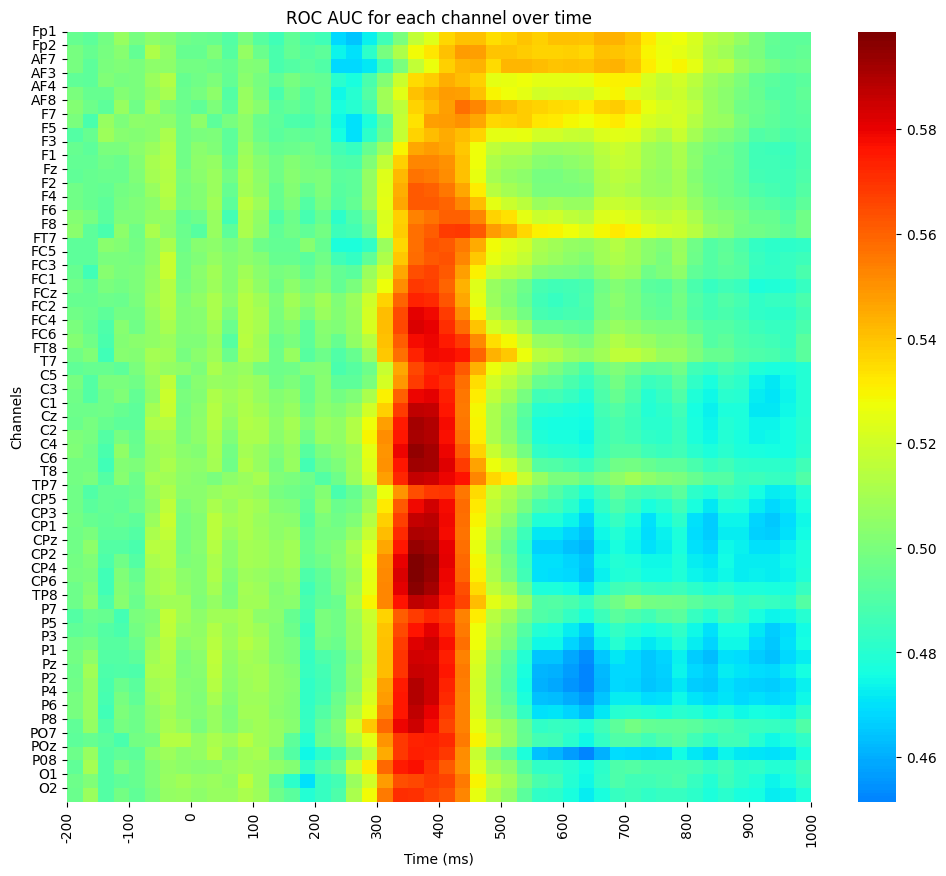

In [ ]:
arr = np.array([channel_to_roc[channel] for channel in eeg_channels])
plt.figure(figsize=(12, 10))
sns.heatmap(arr, cmap='jet', center=0.5)
plt.xticks(np.arange(0, 52, 4), np.arange(-200, 1100, 100), rotation=90)
plt.yticks(np.arange(0, len(eeg_channels)), eeg_channels, rotation=0)
plt.xlabel('Time (ms)')
plt.ylabel('Channels')
plt.title('ROC AUC for each channel over time')
plt.show()

evidently, among others, the interval around 300-450 ms looks interesting.

Let's look at the topographies of the ROC scores for each of the time windows

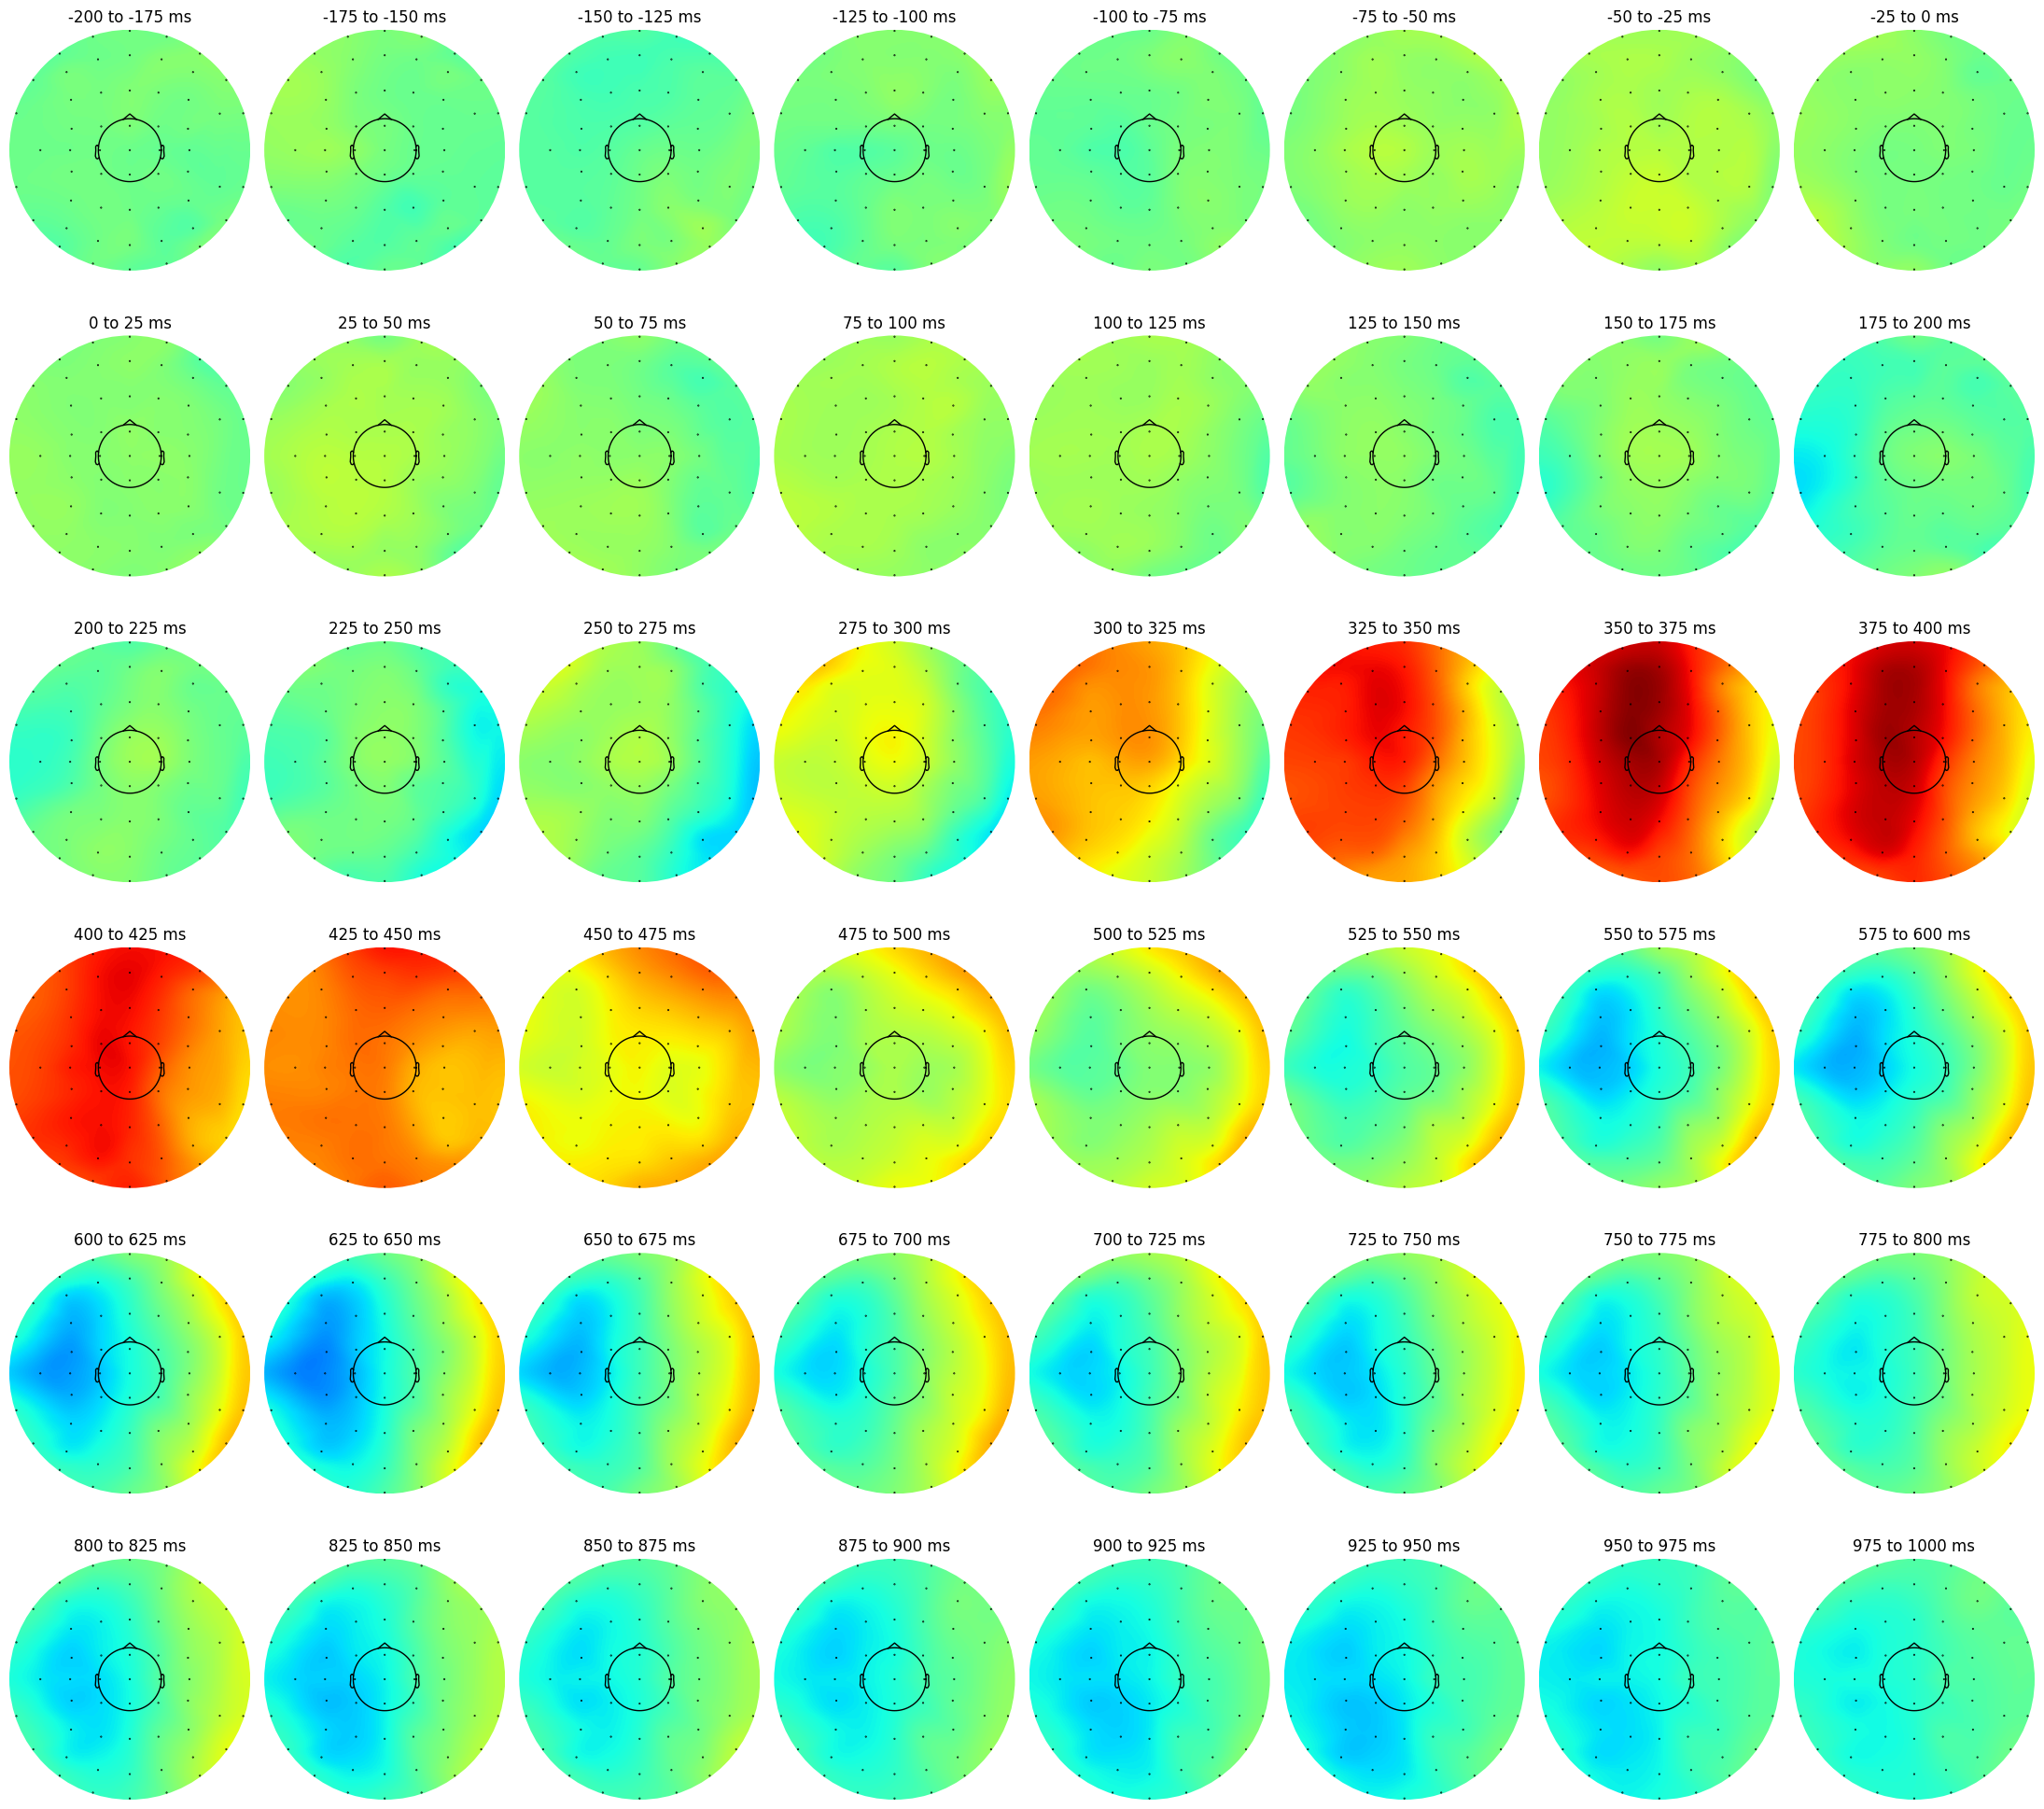

In [ ]:
# Load CSV
df = pd.read_csv("ChannelsLocation.csv")

# Convert spherical (Radius, Phi) -> Cartesian (X, Y, Z)
df["Phi"] = np.deg2rad(df["Phi"])  # Convert degrees to radians
df["X"] = df["Radius"] * np.cos(df["Phi"])
df["Y"] = df["Radius"] * np.sin(df["Phi"])
df["Z"] = np.zeros(len(df))  # Assume all electrodes lie on a 2D plane

# Create Montage
ch_pos = {row["Labels"]: [row["X"], row["Y"], row["Z"]] for _, row in df.iterrows()}
montage = w.channels.make_dig_montage(ch_pos, coord_frame="head")

# Create info object
ch_names = list(df["Labels"])
info = w.create_info(ch_names, sfreq=200, ch_types="eeg")
info.set_montage(montage)

# Example: Plot Topomap with Random Data
f, ax = plt.subplots(6, 8, figsize=(22, 20))
ax = ax.ravel()

for i in range(0, 48):
    ax[i].set_title(f"{(i - 8)*25} to {(i - 7)*25} ms")
    w.viz.plot_topomap(arr[:, i], info, size=3, cmap="jet", vlim=(0.4, 0.6), 
                        show=False, outlines="head", axes=ax[i], contours=False)

plt.tight_layout()
plt.show()


Based on the topographies, we can proceed with the intervals from 300 ms to 475 ms.

Having identified the time intervals, let's prepare our dataset

In [ ]:
X = []
features = [f"{channel}_{time_point * 5 - 200}" for channel in eeg_channels for time_point in range(100, 135, 5)]

for channel in tqdm(eeg_channels):
    channel_data = [epoch[channel].values for epoch in all_epochs]
    channel_data = np.array(channel_data)
    for time_point in range(80, 115, 5):
        time_window_data = channel_data[:, time_point:time_point+5].mean(axis=1) # average voltage over 5 time points (25ms)
        X.append(time_window_data) # append the time window data to the list of all epochs in the session

X = np.array(X).T # Transpose to get shape (n_samples, n_features)
X_train, X_test, y_train, y_test = train_test_split(X, all_labels, test_size=0.2, random_state=42)

100%|██████████| 56/56 [00:02<00:00, 27.81it/s]


Now we can run PCA on the training set

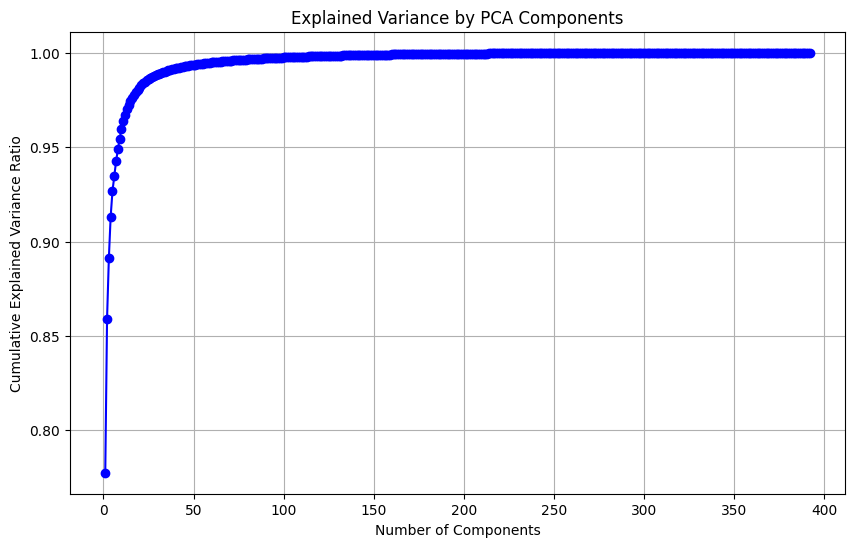

Number of components to explain variance:
80.0% variance: 2 components
85.0% variance: 2 components
90.0% variance: 4 components
95.0% variance: 9 components
97.5% variance: 16 components


In [9]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Perform PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

# Determine number of components for different variance thresholds
variance_thresholds = [0.80, 0.85, 0.90, 0.95, 0.975]
components_for_thresholds = {
    threshold: np.argmax(cumulative_variance_ratio >= threshold) + 1 
    for threshold in variance_thresholds
}

print("Number of components to explain variance:")
for threshold, num_components in components_for_thresholds.items():
    print(f"{threshold*100}% variance: {num_components} components")

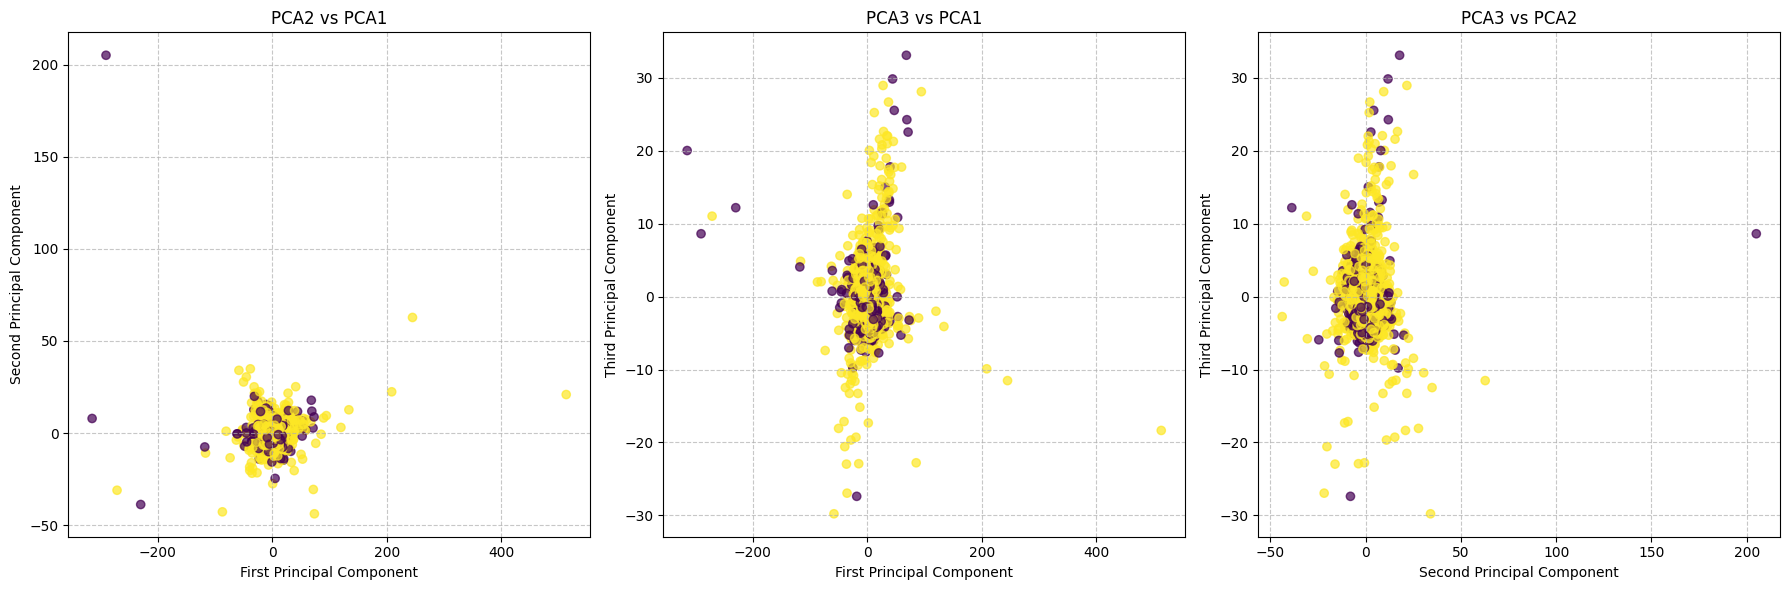

Variance explained by first 3 principal components:
PC1: 0.7776 (77.76%)
PC2: 0.0816 (8.16%)
PC3: 0.0320 (3.20%)
Total: 0.8912 (89.12%)


In [ ]:
# Create a figure with 3 subplots for PCA visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot PCA2 vs PCA1
scatter1 = axes[0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', alpha=0.7)
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')
axes[0].set_title('PCA2 vs PCA1')
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot PCA3 vs PCA1
scatter2 = axes[1].scatter(X_train_pca[:, 0], X_train_pca[:, 2], c=y_train, cmap='viridis', alpha=0.7)
axes[1].set_xlabel('First Principal Component')
axes[1].set_ylabel('Third Principal Component')
axes[1].set_title('PCA3 vs PCA1')
axes[1].grid(True, linestyle='--', alpha=0.7)

# Plot PCA3 vs PCA2
scatter3 = axes[2].scatter(X_train_pca[:, 1], X_train_pca[:, 2], c=y_train, cmap='viridis', alpha=0.7)
axes[2].set_xlabel('Second Principal Component')
axes[2].set_ylabel('Third Principal Component')
axes[2].set_title('PCA3 vs PCA2')
axes[2].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Display variance explained by the first three components
print(f"Variance explained by first 3 principal components:")
print(f"PC1: {explained_variance_ratio[0]:.4f} ({explained_variance_ratio[0]*100:.2f}%)")
print(f"PC2: {explained_variance_ratio[1]:.4f} ({explained_variance_ratio[1]*100:.2f}%)")
print(f"PC3: {explained_variance_ratio[2]:.4f} ({explained_variance_ratio[2]*100:.2f}%)")
print(f"Total: {sum(explained_variance_ratio[:3]):.4f} ({sum(explained_variance_ratio[:3])*100:.2f}%)")

In [15]:
X_train_pca.shape

(4352, 392)

## LDA

The PCA features allow us to fit an LDA model on this dataset

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.31      0.40       303
           1       0.77      0.89      0.83       785

    accuracy                           0.73      1088
   macro avg       0.65      0.60      0.61      1088
weighted avg       0.71      0.73      0.71      1088



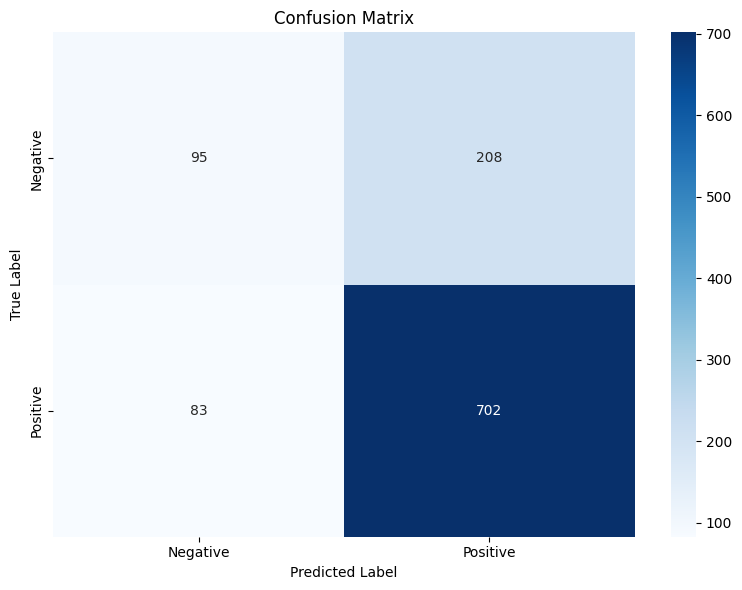

ROC AUC Score: 0.6039


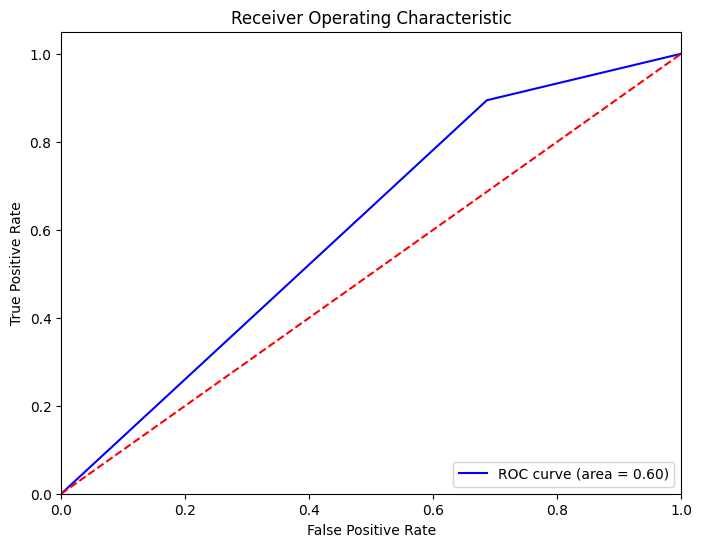

In [16]:
# Create an LDA model
lda = LDA()
lda.fit(X_train_pca, y_train)

X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)
y_pred = lda.predict(X_test_pca)

# Calculate metrics
conf_matrix = confusion_matrix(y_test, y_pred)

# Print metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix display
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# ROC AUC for LDA:
from sklearn.metrics import roc_auc_score, roc_curve

roc_auc_score_value = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc_score_value:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc_score_value)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()